# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

### Battle of the Neighborhoods in Austin, TX - Where to open an Indian restaurant?

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem

Austin is the capital city of Texas in United States and is the fourth largest city in Texas and fourteenth largest city in United States. It has been one of the fastest growing large cities in the United States since 2010. The city consistently appears as one of the best cities to live in and best city to move and retire and is also considered as the most livable city based on its amenities, crime rates, cost of living, housing, and other factors. Austin, Texas offers a unique diversity of lifestyles within its boundaries, making the city an option for people in every walk of life. It is also known for its outstanding food and great live music venues. 
Being a fast-growing city with diversified ethnicities, Austin can be a great place to start a business. Austin is better known for amazing Mexican food, Italian restaurants and in most recent years’ sushi bars. But when it comes to Indian food, it may not be the first thing that comes to our mind when we think of ethnic food. Having lived in Austin for a few years, there are not many authentic Indian restaurants in Austin and would love to see more. To open an Indian restaurant, it requires some serious considerations, one of them is the location which affects the success or failure of the business. 
The objective of this project is to analyze and select the best location in the city of Austin to open a new Indian restaurant.  In this project I will
1) collect neighborhood data from Austin City Government,

2) use Foursquare API to find the top 100 venues within a radius of 1500 meters of the center of the neighborhoods,

3) run k-means clustering on the data to cluster neighborhoods,

4) I will also analyze demographic data for the neighborhoods and discuss data-driven decision making for a new Indian restaurant business in the city of Austin.

### Target Audience
The target audience would be the people who are interested in opening or growing an Indian restaurant. The results obtained or the data obtained through cluster analysis would be useful for entrepreneurs who would want to know more about a particular location which is best suited for them to open a restaurant. 

## Data

To solve the problem, we will need the following data:
•	Austin data containing the zip codes.
•	Latitudes and Longitudes of those neighborhoods to plot the map and get the venues.
•	Venue data particularly the data related to restaurants.
The Austin data is extracted from http://zipatlas.com/us/tx/austin/zip-code-comparison/percentage-indian-population.htm . It is from the website named ZipAtlas, where it is a structured collection of zip codes, area codes, city and state demographic, social and economic profiles. The data extracted from this website consists of Austin zip codes, location and demographics.
All data related to locations of Indian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## Methodology



### Data Acquisition and Cleaning

In [142]:
# Import the library we use to open URL 
import urllib.request 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Data visualization modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 

# map rendering library
import folium 

print('Libraries imported.')

Libraries imported.


### Data Sources

The data is collected from ZipAtlas website where the data consists of the zip code of austin and its latitude and longitude and also information on demographics which can be used later in this project to analyze.

In [143]:
# Read the data in pandas dataframe.

df = pd.read_csv('C:/Users/monal/Desktop/Zipcode.csv')
df.head()

,#,Zip Code,Latitude,Longitude,City,Population,%Indians(Asian),National Rank
0,1,78705,30.293474,-97.738268,"Austin, Texas",26825,0.0463,#162
1,2,78728,30.453764,-97.686695,"Austin, Texas",17298,0.0425,#202
2,3,78726,30.430488,-97.842530,"Austin, Texas",6480,0.0347,#292
3,4,78717,30.488309,-97.764829,"Austin, Texas",8148,0.0271,#453
4,5,78759,30.400789,-97.755969,"Austin, Texas",40547,0.0254,#499


In [144]:
df.shape


(43, 8)

According to the shape of the dataset, there are 42 zipcodes in Austin.

In [145]:
# dropping data which is not required for the project.

df = df.drop(['#', 'Population', 'National Rank'], axis = 1)
df.head()

,Zip Code,Latitude,Longitude,City,%Indians(Asian)
0,78705,30.293474,-97.738268,"Austin, Texas",0.0463
1,78728,30.453764,-97.686695,"Austin, Texas",0.0425
2,78726,30.430488,-97.842530,"Austin, Texas",0.0347
3,78717,30.488309,-97.764829,"Austin, Texas",0.0271
4,78759,30.400789,-97.755969,"Austin, Texas",0.0254


In [146]:
df = df.drop(['%Indians(Asian)'], axis = 1)
df.head()

,Zip Code,Latitude,Longitude,City
0,78705,30.293474,-97.738268,"Austin, Texas"
1,78728,30.453764,-97.686695,"Austin, Texas"
2,78726,30.430488,-97.842530,"Austin, Texas"
3,78717,30.488309,-97.764829,"Austin, Texas"
4,78759,30.400789,-97.755969,"Austin, Texas"


In [147]:
df.shape

(43, 4)

### Explore Zip Codes

After getting the data which contains both latitudes and longitudes, we can then use Folium to map out all the zipcodes.

In [148]:
# create map of Austin using latitude and longitude values
map_austin = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

# add markers to map
for latitude, longitude, ZipCode in zip(df['Latitude'], df['Longitude'], df['Zip Code']):
    label = '{}'.format(ZipCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.9,
        parse_html=False).add_to(map_austin)  
    
map_austin

In [109]:
map_austin.save('map1_austin.html')

Now it's time to find the venues around the center of these zipcodes. I will request this data from Foursquare API and collect information for the top 100 venues in the zipcodes within a radius of 1500 meters.

In [149]:
# Define Foursquare credentials 

CLIENT_ID = 'CZIBZZ2DO3UGMDGQEZUTPGUSOMANFUPSXSYGNYXBRBFEYG2Z' # your Foursquare ID
CLIENT_SECRET = 'Y2XSOSJZUSWUT4JPLL3THLKCMPX1O0IG5PCU0Q4KEAD00EXF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CZIBZZ2DO3UGMDGQEZUTPGUSOMANFUPSXSYGNYXBRBFEYG2Z
CLIENT_SECRET:Y2XSOSJZUSWUT4JPLL3THLKCMPX1O0IG5PCU0Q4KEAD00EXF


In [150]:
# Create function that gets the top 100 venues that are in the zipcode within a radius of 1500 meters 
def getNearbyVenues (names, latitudes, longitudes, radius= 1500):
    
    venue_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venue_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venue_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [151]:
austin_venues = getNearbyVenues(names=df['Zip Code'],
                                  latitudes=df['Latitude'],
                                  longitudes=df['Longitude']
                                  )

78705
78728
78726
78717
78759
78727
78758
78746
78730
78751
78729
78733
78701
78739
78731
78750
78732
78741
78749
78735
78753
78722
78754
78752
78738
78703
78745
78748
78757
78725
78736
78704
78756
78723
78744
78737
78747
78702
78719
78734
78724
78721
78742


In [152]:
austin_venues.head()

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,78705,30.293474,-97.738268,Torchy's Tacos,30.293710,-97.741728,Taco Place
1,78705,30.293474,-97.738268,Taco Joint,30.291486,-97.734978,Mexican Restaurant
2,78705,30.293474,-97.738268,Spiderhouse Ballroom,30.295268,-97.742154,Music Venue
3,78705,30.293474,-97.738268,Juiceland,30.295355,-97.742853,Juice Bar
4,78705,30.293474,-97.738268,Spider House Patio Bar & Cafe,30.295479,-97.741725,Bar


In [153]:
austin_venues.shape

(1629, 7)

Here we group the venues by the neighborhood and we can see that some zipcodes have more venues closer together while other venues are more spaced out.

In [154]:
# Group venues by Zip Code

austin_venues.groupby('Zip Code').count()

,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Zip Code,,,,,,
78701,100,100,100,100,100,100
78702,100,100,100,100,100,100
78703,41,41,41,41,41,41
78704,100,100,100,100,100,100
78705,100,100,100,100,100,100
78717,37,37,37,37,37,37
78719,12,12,12,12,12,12
78721,22,22,22,22,22,22
78722,100,100,100,100,100,100


In [155]:
print('There are {} unique categories.'.format(len(austin_venues['Venue Category'].unique())))

There are 286 unique categories.


### Explore Indian Restaurants in Austin

Before we get into clustering, I'm creating a new dataframe with all the Indian restaurants data that was returned by Foursquare API.

In [156]:
ind_food = austin_venues[austin_venues['Venue Category'].str.contains("Indian Restaurant")]
ind_food.shape

(7, 7)

In [157]:
ind_food

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
85,78705,30.293474,-97.738268,Teji's Indian Restaurant,30.283947,-97.742057,Indian Restaurant
154,78717,30.488309,-97.764829,Subprabhat,30.478390,-97.766471,Indian Restaurant
520,78701,30.271653,-97.741553,The Clay Pit,30.279001,-97.742453,Indian Restaurant
898,78752,30.331288,-97.704660,Taj Palace,30.328851,-97.707309,Indian Restaurant
1150,78757,30.351934,-97.732827,Tarka Indian Kitchen,30.357091,-97.735322,Indian Restaurant
1184,78757,30.351934,-97.732827,Star Of India,30.359569,-97.736675,Indian Restaurant
1518,78702,30.263909,-97.714495,Vixen’s Wedding,30.261640,-97.722683,Indian Restaurant


In [158]:
# create map of Austin using latitude and longitude values
ind_food_map = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

# add markers to map
for latitude, longitude, name in zip(ind_food['Venue Latitude'], ind_food['Venue Longitude'], ind_food['Venue']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='lightpink',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(ind_food_map)  
    
ind_food_map

In [21]:
print('There are approximately {} Indian restaurants in Austin'.format((ind_food['Venue'].count())))

There are approximately 7 Indian restaurants in Austin


## Analysis

### One Hot Encoding

To run machine learning algorithms on the data, we need numerical data about the existence of these venues.One hot encoding helps us do that by creating new (binary) columns to indicate the presence of each possible value from the original data. This means that each venue in each zip code will be labeled as 1 in their correct category. After this, we group the dataframe by the zip codes to get the mean of the frequency of occurrence of each venue category.

###  Analyze Zip Codes

In [159]:
# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add Zip Code column back to dataframe
austin_onehot['Zip Code'] = austin_venues['Zip Code'] 

# move Zip Code column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

austin_onehot.head()

,Zip Code,Adult Boutique,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bike Trail,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Carpet Store,Cemetery,Cheese Shop,Chinese Restaurant,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Trade School,Trail,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings 

In [160]:
austin_grouped = austin_onehot.groupby('Zip Code').mean().reset_index()
austin_grouped.head()

,Zip Code,Adult Boutique,Airport,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Shop,Bike Trail,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Carpet Store,Cemetery,Cheese Shop,Chinese Restaurant,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Ski Shop,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Steakhouse,Storage Facility,Student Center,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Trade School,Trail,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waterfall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings 

In [161]:
austin_grouped.shape

(42, 287)

###  Indian Restaurant One Hot Encoding

From the previous data frame(austin_grouped), we use the Indian restaurants category as a filter to tell us the average frequency of occurance of Indian restaurants in each Zip Code.

In [162]:
ind_res = austin_grouped[['Zip Code', 'Indian Restaurant']]
ind_res.head()

,Zip Code,Indian Restaurant
0,78701,0.01
1,78702,0.01
2,78703,0.00
3,78704,0.00
4,78705,0.01


In [163]:
ind_res.shape

(42, 2)

###  Run K-Means to Cluster Zip Codes

In [164]:
ind_cluster = ind_res.drop('Zip Code', 1)

In [165]:
# Run k-means to cluster neighbourhoods into 3 clusters

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ind_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 1, 1, 3, 2, 1, 1, 1, 1])

In [166]:
ind_cluster.shape

(42, 1)

In [167]:
ind_res.head()

,Zip Code,Indian Restaurant
0,78701,0.01
1,78702,0.01
2,78703,0.00
3,78704,0.00
4,78705,0.01


In [171]:
# add clustering labels
ind_res.insert(0, 'Cluster Labels', kmeans.labels_)

ind_merged = df

# merge ind_merged with austin_data to add latitude/longitude for each neighborhood
ind_merged = ind_merged.join(ind_res.set_index('Zip Code'), on='Zip Code')

ind_merged.dropna(inplace=True)
ind_merged.head()

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
0,78705,30.293474,-97.738268,"Austin, Texas",3.0,0.010000
1,78728,30.453764,-97.686695,"Austin, Texas",1.0,0.000000
2,78726,30.430488,-97.842530,"Austin, Texas",1.0,0.000000
3,78717,30.488309,-97.764829,"Austin, Texas",2.0,0.027027
4,78759,30.400789,-97.755969,"Austin, Texas",1.0,0.000000


In [172]:
ind_merged.shape

(42, 6)

### Examine Clusters

We created 4 clusters (cluster 0 - 3) using k-means. Now let's look at each cluster.

### Cluster0

In this cluster we can see that there are a few Indian restuarants.

In [173]:
cluster0 = ind_merged.loc[ind_merged['Cluster Labels'] == 0]
cluster0

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
23,78752,30.331288,-97.70466,"Austin, Texas",0.0,0.013889


### Cluster1

When compared to cluster0, cluster1 has an average frequency of zero. This means that there are not many Indian Restuarants in these zip codes.

In [174]:
cluster1 = ind_merged.loc[ind_merged['Cluster Labels'] == 1]
cluster1

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
1,78728,30.453764,-97.686695,"Austin, Texas",1.0,0.0
2,78726,30.430488,-97.842530,"Austin, Texas",1.0,0.0
4,78759,30.400789,-97.755969,"Austin, Texas",1.0,0.0
5,78727,30.428300,-97.718143,"Austin, Texas",1.0,0.0
6,78758,30.387634,-97.705310,"Austin, Texas",1.0,0.0
7,78746,30.296951,-97.811647,"Austin, Texas",1.0,0.0
8,78730,30.363632,-97.850355,"Austin, Texas",1.0,0.0
9,78751,30.310819,-97.722821,"Austin, Texas",1.0,0.0
10,78729,30.457246,-97.756419,"Austin, Texas",1.0,0.0
11,78733,30.323857,-97.894860,"Austin, Texas",1.0,0.0


### Cluster2

In [175]:
cluster2 = ind_merged.loc[ind_merged['Cluster Labels'] == 2]
cluster2

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
3,78717,30.488309,-97.764829,"Austin, Texas",2.0,0.027027
28,78757,30.351934,-97.732827,"Austin, Texas",2.0,0.024096


### Cluster3

In [176]:
cluster3 = ind_merged.loc[ind_merged['Cluster Labels'] == 3]
cluster3

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
0,78705,30.293474,-97.738268,"Austin, Texas",3.0,0.01
12,78701,30.271653,-97.741553,"Austin, Texas",3.0,0.01
37,78702,30.263909,-97.714495,"Austin, Texas",3.0,0.01


In [177]:
clusters = ind_merged.groupby('Zip Code').mean()
clusters.head()

,Latitude,Longitude,Cluster Labels,Indian Restaurant
Zip Code,,,,
78701,30.271653,-97.741553,3.0,0.01
78702,30.263909,-97.714495,3.0,0.01
78703,30.294204,-97.765114,1.0,0.00
78704,30.243128,-97.765874,1.0,0.00
78705,30.293474,-97.738268,3.0,0.01


In [178]:
c0 = clusters.loc[clusters['Cluster Labels'] == 0]
c1 = clusters.loc[clusters['Cluster Labels'] == 1]
c2 = clusters.loc[clusters['Cluster Labels'] == 2]
c3 = clusters.loc[clusters['Cluster Labels'] == 3]

In [179]:
print('Cluster 0 has an average frequency of Indian Restaurants of', c0["Indian Restaurant"].mean())
print('Cluster 1 has an average frequency of Indian Restaurants of', c1["Indian Restaurant"].mean())
print('Cluster 2 has an average frequency of Indian Restaurants of', c2["Indian Restaurant"].mean())
print('Cluster 3 has an average frequency of Indian Restaurants of', c3["Indian Restaurant"].mean())

Cluster 0 has an average frequency of Indian Restaurants of 0.013888888888888888
Cluster 1 has an average frequency of Indian Restaurants of 0.0
Cluster 2 has an average frequency of Indian Restaurants of 0.025561706284597852
Cluster 3 has an average frequency of Indian Restaurants of 0.01


After looking at each cluster, we can say that cluster2 has the highest frequency whereas cluster1 has the lowest.

### Indian Resturant Data with Cluster Labels

In [180]:
ind_f = ind_food.join(ind_res.set_index('Zip Code'), on='Zip Code')
ind_f.reset_index(drop = True)

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,Indian Restaurant
0,78705,30.293474,-97.738268,Teji's Indian Restaurant,30.283947,-97.742057,Indian Restaurant,3,0.010000
1,78717,30.488309,-97.764829,Subprabhat,30.478390,-97.766471,Indian Restaurant,2,0.027027
2,78701,30.271653,-97.741553,The Clay Pit,30.279001,-97.742453,Indian Restaurant,3,0.010000
3,78752,30.331288,-97.704660,Taj Palace,30.328851,-97.707309,Indian Restaurant,0,0.013889
4,78757,30.351934,-97.732827,Tarka Indian Kitchen,30.357091,-97.735322,Indian Restaurant,2,0.024096
5,78757,30.351934,-97.732827,Star Of India,30.359569,-97.736675,Indian Restaurant,2,0.024096
6,78702,30.263909,-97.714495,Vixen’s Wedding,30.261640,-97.722683,Indian Restaurant,3,0.010000


Let's create a map to examine these clusters further.

In [181]:
map_clusters = folium.Map(location=[30.2672, -97.7431], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, zipcode, cluster, in zip(ind_merged['Latitude'], ind_merged['Longitude'], ind_merged['Zip Code'],  
                                            ind_merged['Cluster Labels']):
    label = folium.Popup(str(zipcode) + '- Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        tooltip = str(zipcode) + '- Cluster ' + str(cluster),
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [99]:
map_clusters.save('map_clusters.html')

Cluster0-Red, Cluster1-Purple, Cluster2-Light Green, Cluster3-Blue.
From the map, we can observe that most of the Indian Restaurants are located in Central part of Austin. Cluster0 and Cluster3 are located in the central part of the city whereas Cluster2 which has the highest frequency of Indian restaurants is located towards north of Austin. 

Text(0.5, 1.0, 'Approximate Number of Indian Restaurants in Each Cluster')

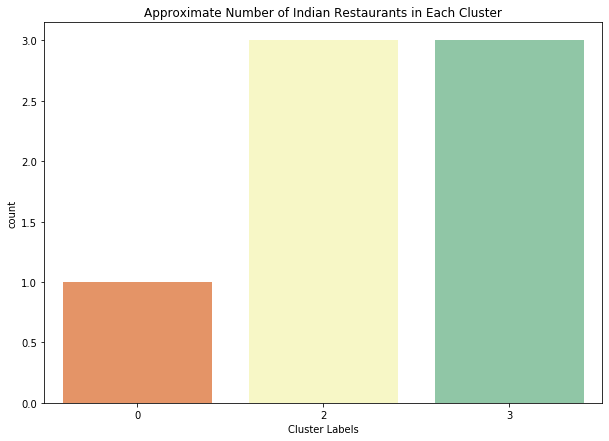

In [182]:
plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (10, 7)

sns.countplot(x=ind_f['Cluster Labels'],data=ind_f, palette = 'Spectral').set_title("Approximate Number of Indian Restaurants in Each Cluster")

From the above graph we can see the approximte number of Indian restaurants in each cluster. Cluster2, cluster3 have the highest number of Indian Restaurants and the frequency of indian restaurants for cluster3 is the lowest when compared to other clusters. This may be because of high number of zip codes when compared to the other clusters, and that the other common venues may make the frequency of indian restaurants lower.

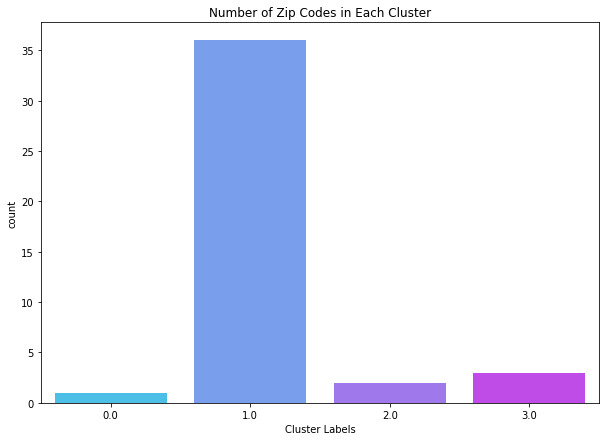

In [183]:
plt.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = (10, 7)

ax = sns.countplot(x=clusters['Cluster Labels'],data=clusters, palette = 'cool').set_title("Number of Zip Codes in Each Cluster")

From this graph we can see that cluster1 has more number of zip codes which do not have Indian restaurants within a radius of 1500 meters. Keeping that in mind we should also note that Foursquare data only returned top 100 venues within 1500 meters and there maybe more Indian restaurants which foursquare did not return.

### Demographics in Austin using zip codes

To open a restaurant there are a lot of factors which are need to be considered. Demographics is one among them. The data used is the same data which I used previously for getting the zip codes, latitudes and longitudes. This dataset consists of same zip codes used previously, latitude, longitude, city, population, percentage of Indians. Percentage of Indians is needed to find out how many Indians live in that particular zip code which will help us with our decision of opening an Indian restaurant.

In [184]:
demographics = pd.read_csv('C:/Users/monal/Desktop/Zipcode.csv')

In [185]:
demographics.head()

,#,Zip Code,Latitude,Longitude,City,Population,%Indians(Asian),National Rank
0,1,78705,30.293474,-97.738268,"Austin, Texas",26825,0.0463,#162
1,2,78728,30.453764,-97.686695,"Austin, Texas",17298,0.0425,#202
2,3,78726,30.430488,-97.842530,"Austin, Texas",6480,0.0347,#292
3,4,78717,30.488309,-97.764829,"Austin, Texas",8148,0.0271,#453
4,5,78759,30.400789,-97.755969,"Austin, Texas",40547,0.0254,#499


In [186]:
indian_population = demographics[['Zip Code', 'Population', '%Indians(Asian)']]
indian_population.head()

,Zip Code,Population,%Indians(Asian)
0,78705,26825,0.0463
1,78728,17298,0.0425
2,78726,6480,0.0347
3,78717,8148,0.0271
4,78759,40547,0.0254


In [187]:
ind_2 = ind_merged

In [188]:
ind_2.head()

,Zip Code,Latitude,Longitude,City,Cluster Labels,Indian Restaurant
0,78705,30.293474,-97.738268,"Austin, Texas",3.0,0.010000
1,78728,30.453764,-97.686695,"Austin, Texas",1.0,0.000000
2,78726,30.430488,-97.842530,"Austin, Texas",1.0,0.000000
3,78717,30.488309,-97.764829,"Austin, Texas",2.0,0.027027
4,78759,30.400789,-97.755969,"Austin, Texas",1.0,0.000000


In [189]:
# Sort population data by higher percentage to lower
indian_sorted = indian_population.sort_values(by='%Indians(Asian)', ascending=False)
indian_sorted.head()

,Zip Code,Population,%Indians(Asian)
0,78705,26825,0.0463
1,78728,17298,0.0425
2,78726,6480,0.0347
3,78717,8148,0.0271
4,78759,40547,0.0254


### Merge Sorted Population Data with Cluster Data

In [190]:
# merge population data with cluster data
left = indian_sorted
right = ind_2
result = pd.merge(left, right, on=['Zip Code'])

In [191]:
result.head(10)

,Zip Code,Population,%Indians(Asian),Latitude,Longitude,City,Cluster Labels,Indian Restaurant
0,78705,26825,0.0463,30.293474,-97.738268,"Austin, Texas",3.0,0.010000
1,78728,17298,0.0425,30.453764,-97.686695,"Austin, Texas",1.0,0.000000
2,78726,6480,0.0347,30.430488,-97.842530,"Austin, Texas",1.0,0.000000
3,78717,8148,0.0271,30.488309,-97.764829,"Austin, Texas",2.0,0.027027
4,78759,40547,0.0254,30.400789,-97.755969,"Austin, Texas",1.0,0.000000
5,78727,22212,0.0220,30.428300,-97.718143,"Austin, Texas",1.0,0.000000
6,78758,42820,0.0212,30.387634,-97.705310,"Austin, Texas",1.0,0.000000
7,78746,26023,0.0206,30.296951,-97.811647,"Austin, Texas",1.0,0.000000
8,78730,4885,0.0200,30.363632,-97.850355,"Austin, Texas",1.0,0.000000
9,78751,14005,0.0187,30.310819,-97.722821,"Austin, Texas",1.0,0.000000


After sorting and merging the cluster data with population data, we can now see the cluster data along with top 9 zip codes with high percentage of Indian population. From the above table we can observe that most of the top 9 Indian populated zip codes fall in cluster1 which has the lowest frequency of Indian restaurants. And, these zip codes do not have Indian restuarants which is surprising. There are only two zip codes which have Indian restuarnats which fall into cluster3 and cluster2.

### Data Visualization

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

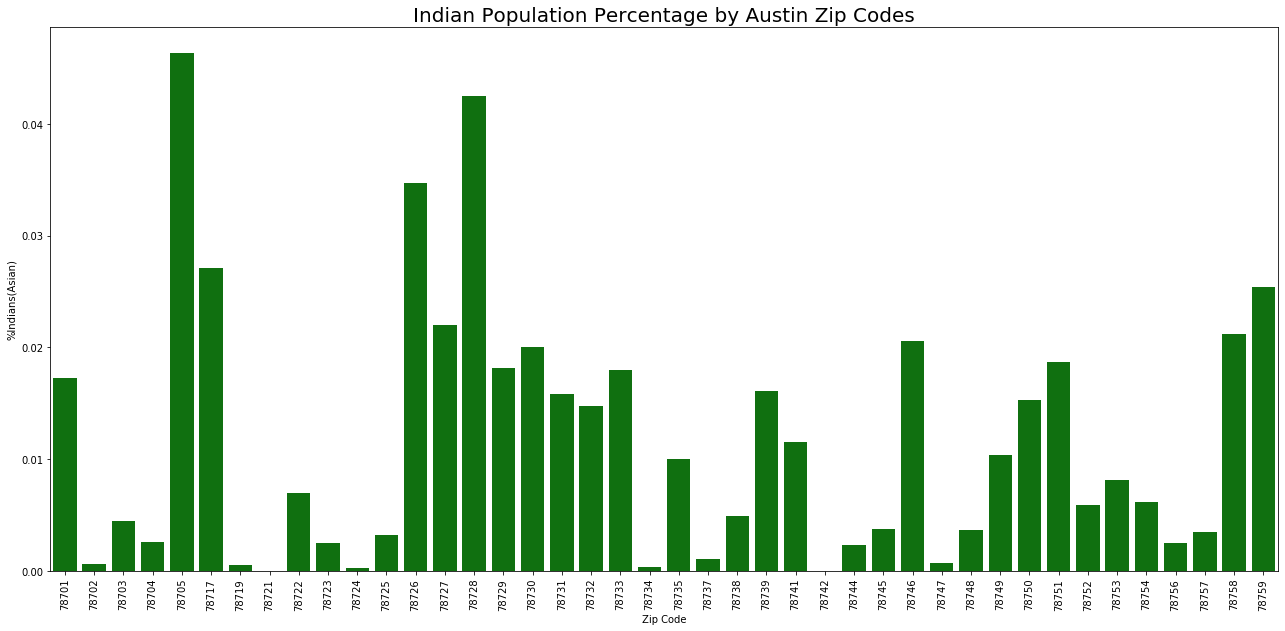

In [192]:
plt.rcParams['figure.figsize'] = (22, 10)
ax1 = sns.barplot(x=result['Zip Code'], y = result['%Indians(Asian)'], data=result, color = 'green').set_title("Indian Population Percentage by Austin Zip Codes", fontsize = 20)
plt.xticks(rotation=90)

### Heatmap by Indian Population Density in Austin

In [193]:
from folium import plugins
from folium.plugins import HeatMap

indian_population_heatmap = folium.Map(location=[30.2672, -97.7431], zoom_start=11)
# create heatmap layer
heatmap = HeatMap( list(zip(result['Latitude'], result['Longitude'], result["%Indians(Asian)"])),
                   min_opacity=0.2,
                   max_val=result["%Indians(Asian)"].max(),
                   radius=50, blur=50, 
                   max_zoom=1)
# add heatmap layer to base map
heatmap.add_to(indian_population_heatmap)
indian_population_heatmap

In [87]:
indian_population_heatmap.save('indian_population_heatmap.html')

# Discussion and Results

Based on our cluster analysis result, we found that cluster2 has highest frequency of Indian restaurants when compared to the rest of the clusters and cluster1 has the lowest. However, we can see that cluster3 has low frequency and high number of Indian restaurants and this maybe because of higher number of zip codes in that cluster. Cluster1 has highest number of zip codes but there are no Indian restaurants. To make a decision on which zip code would be better to open a restaurant, we looked at the demographics of Indian population in those zip codes. When we look at the demographics of top nine zip codes with highest to lowest Indian population, I found that most of the zip codes belong to cluster1. Which means that cluster1 has no Indian restaurants in the areas where the population of Indians are high. The most Indian populated zip code belongs to cluster0. Sometimes the reason for the zip codes having Indian population but no Indian restaurant is because the overall population for those zip codes is low. But there are some zip codes which have high overall population and high Indian population but no restaurants for example zip codes 78759,78758. Therefore, we can take these zip codes into consideration to open an Indian restaurant because they are highly populated as well as they have high Indian population. 

After discussing the possibility of opening an Indian restaurant we should also note some limitations to this analysis. To start with the coordinates taken from the website may not be accurate. They are only an approximation for the zip codes which are given along with the coordinates. The limit set to the Foursquare API for 100 venues within the radius of 1500 meters is also another limitation which has to be considered. This is because there may be other Indian restaurants which were not included in 100 venues and not returned by Foursquare API. Lastly, the data collected for the demographics may also be just an approximation which may have changed. So, before opening a restaurant it is important to know various other factors which lead to success of the restaurant. Many of those factors include consumers, competitors, neighborhoods. For future analysis, considering the neighborhoods where more Indians reside can also give us an insight on where exactly we can open an Indian restaurant which can lead to more success and profits for the restaurant.


# Conclusion

In this project we have gone through the process of identifying the business problem: where to open an Indian restaurant in Austin, Tx. We further collected data from a website which had information on the zip codes and its coordinates and also information on the demographics on Indian population in those zip codes. We then used Foursquare API to collect information on top 100 venues within the radius of 1500 meters in each zip code. We then used cluster analysis to analyze the data which was grouped into 4 clusters in total. From this analysis, we could find the average frequency of Indian restaurants and later used the demographic data to compare the zip codes with high Indian population and average frequency of Indian restaurants. From the results, we concluded that zip codes 78759, 78758  both have high overall population and high Indian population but there were not many Indian restaurants. I would therefore open an Indian restaurant in those zip codes if given a chance based on the cluster analysis results and demographic data which was provided.